In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk

Image ROI Class

In [22]:
class ImageROI:
    def __init__(self):
        pass

    # convert coordinates from slicer spacing to sitk spacing
    # inputs:
    # img -> SimpleITK image
    # slicer_size -> size from slicer resampling, found in volume metadata in slicer
    # slicer_coords -> (x,y,z) coordinates of point in slicer
    def convert_slicer_coordinates(self, img, slicer_size, slicer_coords):
        size_conversion = np.divide(img.GetSize(), slicer_size)
        python_coords_dbl = np.multiply(slicer_coords, size_conversion)
        
        python_coords = []
        for coord in python_coords_dbl:
            python_coords.append(int(coord))
        
        return python_coords

    # create roi image from sitk image
    # inputs:
    # img -> SimpleITK image
    # centroid -> centroid of lung nodule in coordinates using [1,1,1] spacing NOT SLICER
    # expansion -> amount to expand ROI from centroid in +/- for each direction
    def create_roi_image(self, img, expansion, centroid):


        # expand roi from centroid
        roi = {
            'coronal' : [centroid[0]-expansion, centroid[0]+expansion],
            'sagittal' : [centroid[1]-expansion, centroid[1]+expansion],
            'axial' : [centroid[2]-expansion, centroid[2]+expansion]
        }

        # convert to numpy array and cut down to roi around nodule centroid
        np_img = sitk.GetArrayFromImage(img)
        np_roi = np_img[roi['axial'][0]:roi['axial'][1],
                        roi['sagittal'][0]:roi['sagittal'][1],
                        roi['coronal'][0]:roi['coronal'][1]]

        # return a SimpleITK image bounded in ROI
        return sitk.GetImageFromArray(np_roi)

    # view all planes of SimpleITK image or numpy array image
    # inputs:
    # img -> either SimpleITK image or numpy array. If using numpy array change param nparray to True
    # slice_inds -> [coronal, sagittal, axial] slice to view
    # min_i -> minimum intensity, defaulted to -100
    # max_i -> maximum intensity, defaulted to 100
    # nparray -> boolean to determine if using a numpy array instead of sitk image, defaulted to false
    def multiview(self, img, slice_inds, min_i = -100, max_i = 100, nparray=False):

        # convert if needed
        if not nparray:
            npim = sitk.GetArrayFromImage(img)
        else:
            npim = img
        
        # Display each slice
        fig, ax = plt.subplots(1,3, figsize = (12,4))
        
        # Display each slice
        ax[0].imshow(npim[:,:,slice_inds[0]], cmap = 'gray', origin = 'lower')
        # Sagittal slice
        ax[1].imshow(npim[:,slice_inds[1],:], cmap = 'gray', origin = 'lower')
        # Coronal slice
        ax[2].imshow(npim[slice_inds[2],:,:], cmap = 'gray') # Axial slice
        # Add title to each view
        planes = ["Sagittal", "Coronal", "Axial"]
        for i,p in enumerate(planes):
            ax[i].set_title(p)
    
        for axis in ax:
            axis.set_axis_off()

    # basic function for resampling an image assuming dcm is already identity matrix
    # inputs:
    # img -> SimpleITK image to be resampled
    def resample_image(self, img):
        resample = sitk.ResampleImageFilter()
    
        k = np.divide([1,1,1], img.GetSpacing())
        
        resample_size_float = np.divide(img.GetSize(), k)
        resample_spacing_float = np.multiply(img.GetSpacing(), k)
        
        resample_size = []
        resample_spacing = [1,1,1]
        
        for idx, dim in enumerate(resample_size_float):
            resample_size.append(int(dim))
        
        resample = sitk.ResampleImageFilter()
        resample.SetOutputOrigin(img.GetOrigin())
        resample.SetSize(resample_size)
        resample.SetOutputSpacing(resample_spacing)
        resample.SetOutputDirection(img.GetDirection())
        resample.SetInterpolator(sitk.sitkLinear)
        
        return resample.Execute(img)

Testing

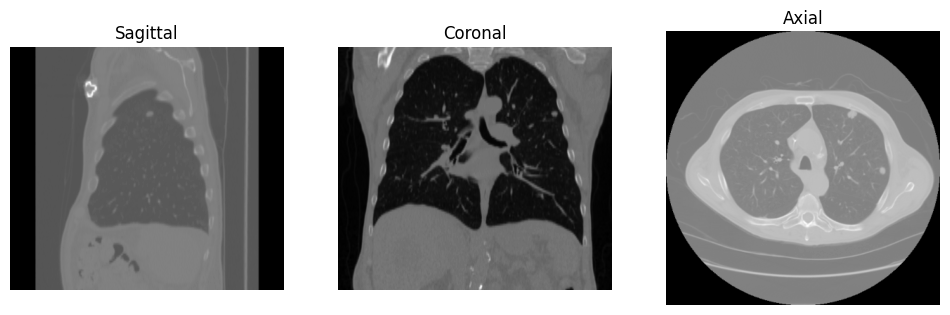

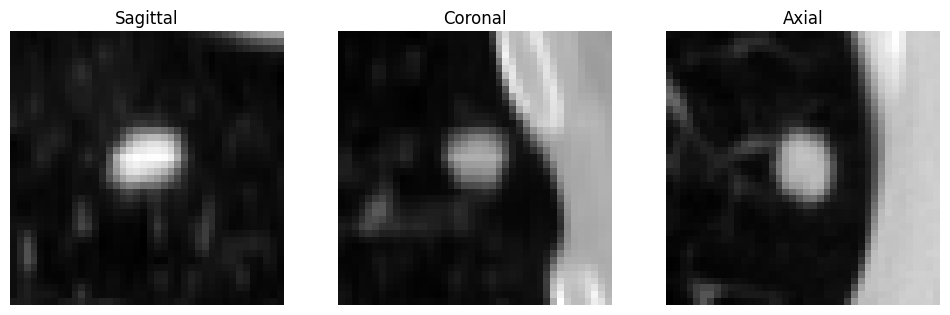

In [23]:
data_dir = 'data//CTChest.nii.gz'
img = sitk.ReadImage(data_dir)

imageROI = ImageROI()

img = imageROI.resample_image(img)
tumor_coordinates_slicer = [405, 262, 100]
tumor_coordinates_converted = imageROI.convert_slicer_coordinates(img, [512, 512, 139], tumor_coordinates_slicer)

imageROI.multiview(img, tumor_coordinates_converted)

expansion_size = 20
roi_img = imageROI.create_roi_image(img, expansion_size, tumor_coordinates_converted)
imageROI.multiview(roi_img, [expansion_size, expansion_size, expansion_size])